In [18]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()

content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

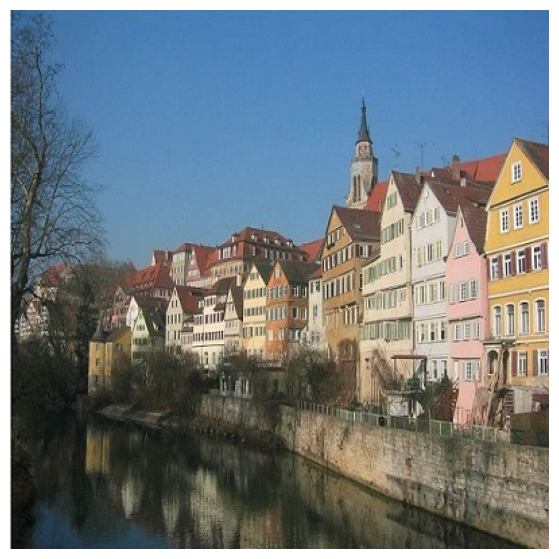

In [19]:
plt.figure(figsize=(15,7))
plt.imshow(content_copy)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

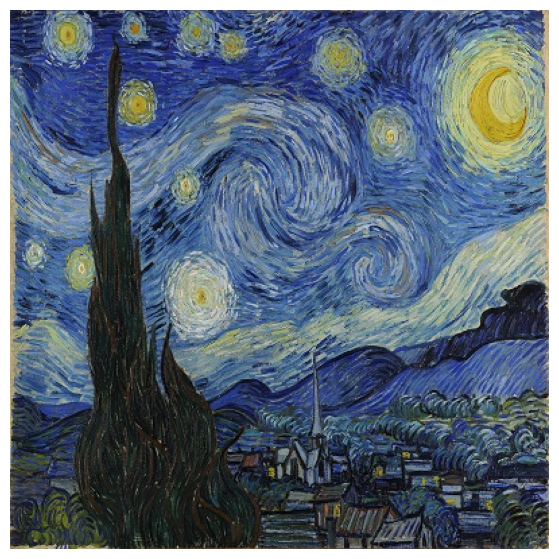

In [20]:
plt.figure(figsize=(15,7))

plt.imshow(style)
plt.axis("off")

In [21]:
# Define a function for style transfer (you need to implement this function)
def color_transfer(content, style, imsize):

        # Initialize variables
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)

    # One-dimensional image
    h0 = imsize
    w0 = imsize

    # number of color channels
    c = 3

    # Convert to 3D arrays
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    # Initialize C to color palette of S using histogram matching
    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

    C0 = cv2.GaussianBlur(C0, (5, 5), 0)
    # Reshape C0 to a 1D array
    C0 = C0.reshape(-1)

    X = C0
    X = X + np.max(X) * np.random.randn(X.size)  # Add large noise at the beginning
    X = X.reshape(h0, w0, c)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


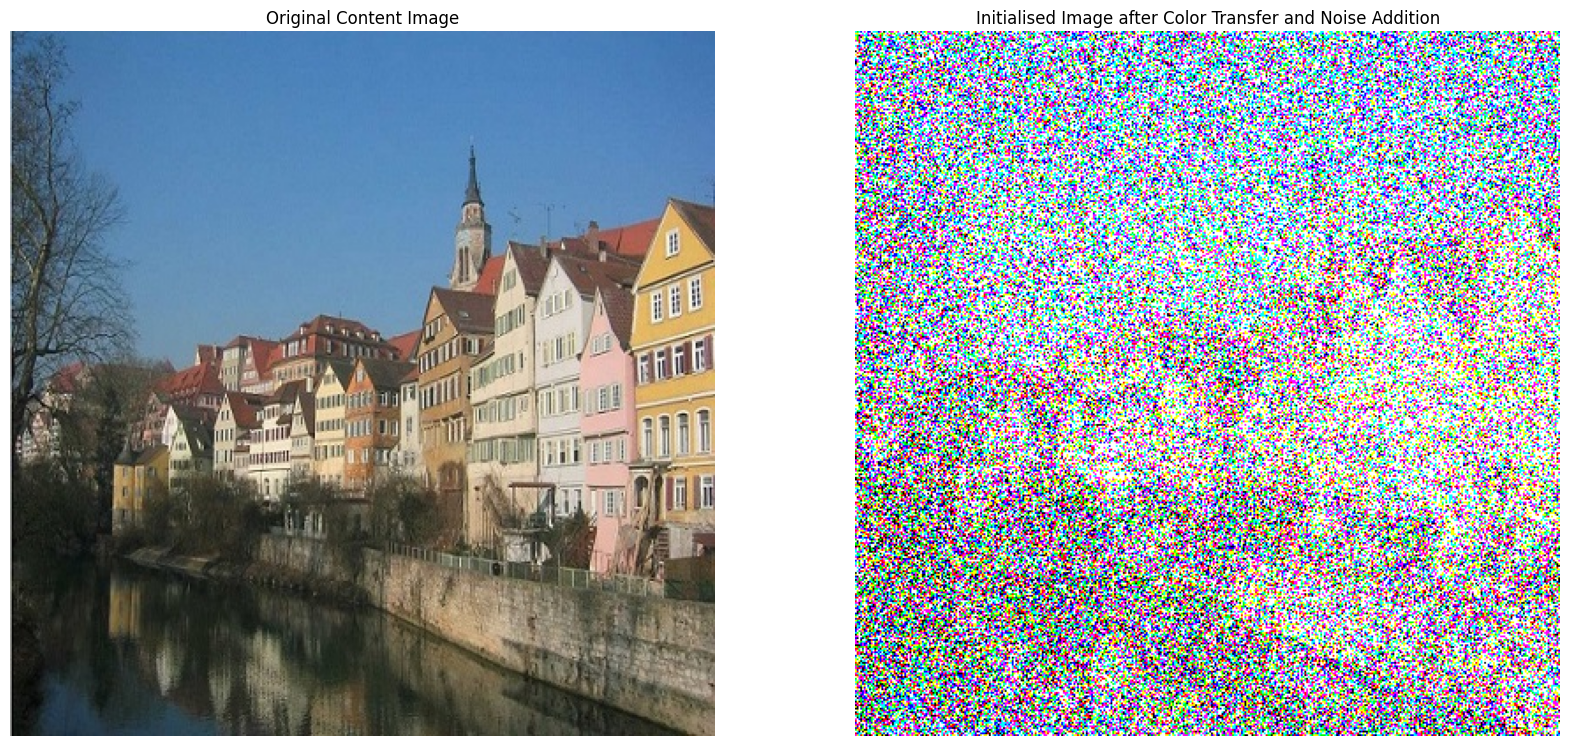

In [22]:
initialised_image = color_transfer(content, style, imsize)
# PLT THIS IMAGE

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Content Image")
plt.imshow(content_copy)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Initialised Image after Color Transfer and Noise Addition") 
plt.imshow(initialised_image)

In [26]:
scales=[4,2,1]
patch_sizes=[36,22]
import math

h0=imsize
w0=imsize

c=3

hall = np.ones((400, 400,3))
mask0= np.ones((400, 400))

for L in scales:

    C_scaled = cv2.resize(np.reshape(content_copy, (h0, w0, c)), None, fx=1/L, fy=1/L)
    S_scaled = cv2.resize(np.reshape(style, (h0, w0, c)), None, fx=1/L, fy=1/L)

    mask = cv2.resize(mask0, None, fx=1/L, fy=1/L)

    C = C_scaled.flatten() 
    S = S_scaled.flatten()

    h = math.ceil(h0/L)
    w = math.ceil(w0/L)

    X = cv2.resize(np.reshape(initialised_image, (h0, w0, c)), (w, h))
    
    halls = cv2.resize(hall, (w, h))

    X = X.flatten()

    for n in patch_sizes:

        if L > 1 and n == 13:
            continue
        Q_size = n
        # Precompute P
        Pstride = 4
        S = S.reshape((h, w, c))
        P = np.zeros((c * Q_size * Q_size, (int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) * 4))

        for k in range(0, h - Q_size + 1, Pstride):
            for j in range(0, w - Q_size + 1, Pstride):
                patch = S[k:k + Q_size, j:j + Q_size, :]
                for l in range(4):
                    temp = rotate(patch, l * 90, reshape=False, mode='reflect', order=1)
                    P[:, (int(k / Pstride) - 1) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride) - 1) * 4 + l + 1] = temp.flatten()

        S = S.flatten()
        # Remove mean from P
        mp = np.mean(P, axis=1)
        P = P - np.tile(mp[:, np.newaxis], (1, P.shape[1]))
        